In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from image_captioning.utils import Vocab, create_datasets, pad_collate_fn
from image_captioning.models import AttentionDecoder
from image_captioning.trainer import Trainer

DATA_PATH = '../data/coco/data/'
img_codes_path = DATA_PATH + 'image_codes.npy'
captions_path = DATA_PATH + 'captions_tokenized.json'
%load_ext autoreload
%autoreload 2

vocab = Vocab(captions_path)
datasets = create_datasets(vocab, img_codes_path, captions_path)

In [2]:
torch.backends.cudnn.benchmark = True
###################
hidden_size = 512
num_layers = 2
dropout = 0.15
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu'
)
###################

model = AttentionDecoder(
    vocab=vocab,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi('<pad>'))
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [3]:
trainer = Trainer(
    model=model,
    datasets=datasets,
    vocab=vocab,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
)

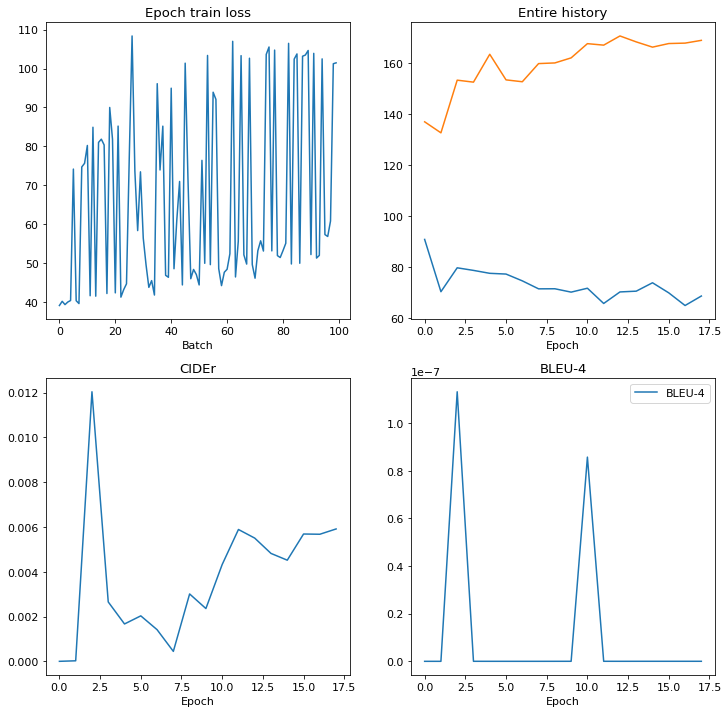

Epoch: 20 | Time: 1m
	Train Loss: 67.392
	  Val Loss: 169.115


In [4]:
trainer.fit(batch_size=1024, epochs=20)

In [10]:
val = datasets['val']
val_loader = DataLoader(datasets['val'], 1000, num_workers=4, collate_fn=pad_collate_fn)

In [11]:
batch_size = 1000
imgs_ids = list(range(len(val_loader) * batch_size))
references = {img_id: caps for (img_id, caps)
              in zip(imgs_ids, val.captions)}
# here we will store predictions
hypotheses = {img_id: [] for img_id in imgs_ids}  
for i, (imgs, captions, lenghts) in enumerate(val_loader):
    imgs = imgs.to(device)
    captions = captions.to(device)
    decode_lenght = max(lenghts - 1)
    
    loss = 0
    hidden = imgs
    decoder_input = captions[:, 0]
    for step in range(decode_lenght):
        logits, hidden = model(imgs, decoder_input, hidden)
        decoder_input = logits.argmax(dim=1)
        
        imgs_ids = [id + i * batch_size for id in range(batch_size)]
        output = decoder_input.cpu().numpy()
        for img_id, token in zip(imgs_ids, output):
            string = vocab.itos(int(token))
            if string not in ['<eos>', '<pad>']:
                hypotheses[img_id].append(string)
                
        targets = captions[:, step + 1]
        loss += criterion(logits, targets)